In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from numpy import mean
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_rows", 40)

data = pd.read_csv('application_train.csv', index_col='SK_ID_CURR')
data_test = pd.read_csv('application_test.csv', index_col='SK_ID_CURR')
continuous_features = set()
discrete_features = set()

categorical_features = set()

In [3]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

In [4]:
categorical_features |= set(data.select_dtypes(include=['object']).columns)
# to_add = {
#     "TARGET", "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", 
#     "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION",
#     "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY",
#     "LIVE_CITY_NOT_WORK_CITY", 
# }
# categorical_features |= to_add
# for column in data.columns:
#     if column.startswith('FLAG'):
#         categorical_features.add(column)
        
# for feature in categorical_features:
#     data[feature] = data[feature].astype("category")
categorical_features

{'CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE',
 'WEEKDAY_APPR_PROCESS_START'}

In [5]:
for column in data.columns:
    if column not in categorical_features:
        if data[column].nunique() <= 6:
            discrete_features.add(column)
        else:
            continuous_features.add(column)

numerical_features = discrete_features | continuous_features

In [6]:
# Missing values

def missing_values_table(df):
    missing_value = df.isnull().sum()
    missing_value_percentage = 100 * df.isnull().sum() / len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percentage], axis=1)
    missing_value_table = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    missing_value_table = missing_value_table[missing_value_table.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1)
    return missing_value_table

missing_values_table(data)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [7]:
# Duplicated rows

data[data.duplicated()]

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,


In [8]:
data.describe(include='all')

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [9]:
def plot_categorical_discrete(data, col, x_angle=0, title=''):
    plot_data = data[col].value_counts()
    plt.figure(figsize=[12, 4])
    sns.barplot(x=plot_data.index, y=plot_data.values)
    plt.xticks(rotation=x_angle)
    plt.title(title)
    plt.show()
    
def plot_continuous(data, col, type_='hist', title=''):
    plt.figure(figsize=[12, 4])
    plt.title(title)
    if type_ == 'hist':
        sns.histplot(data[col].dropna(), bins=50, kde=True, color="g")
    elif type_ == 'box':
        sns.boxplot(data[col].dropna())
    plt.show()

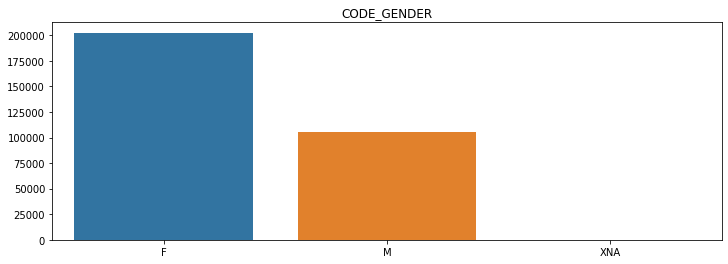

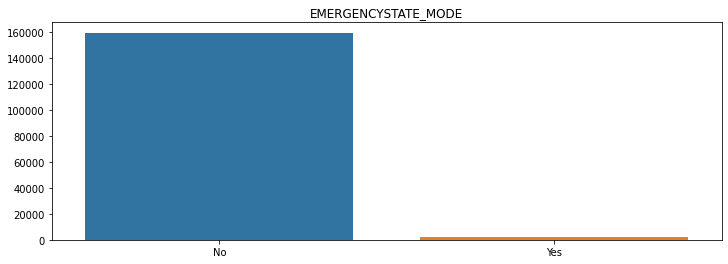

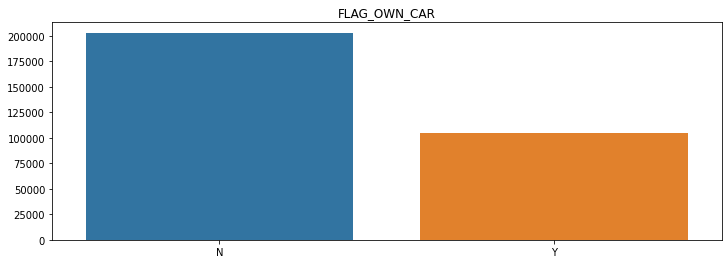

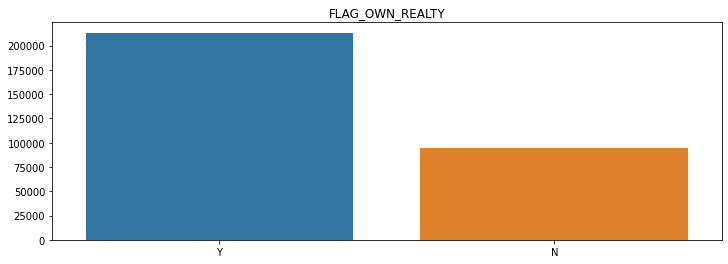

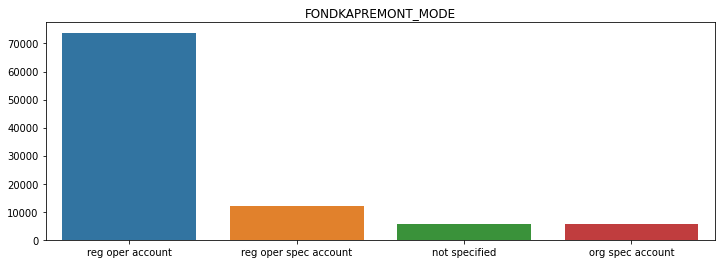

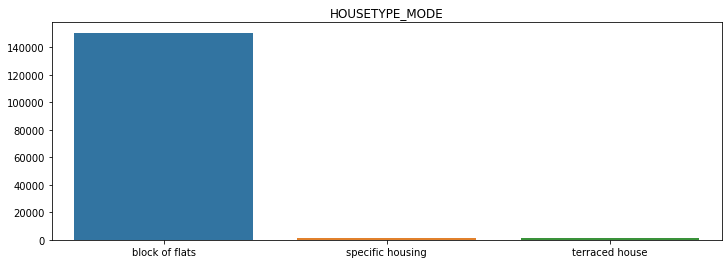

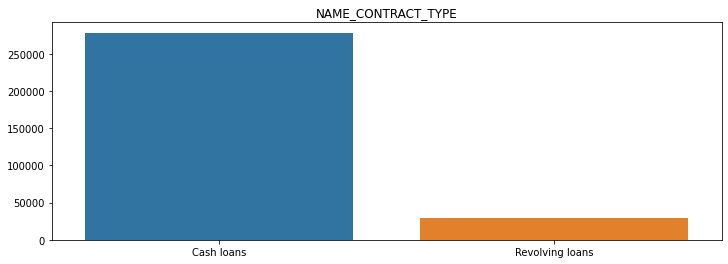

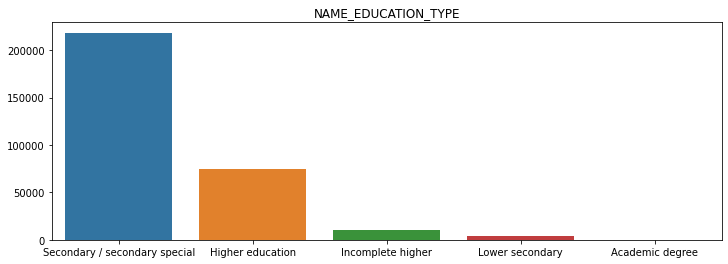

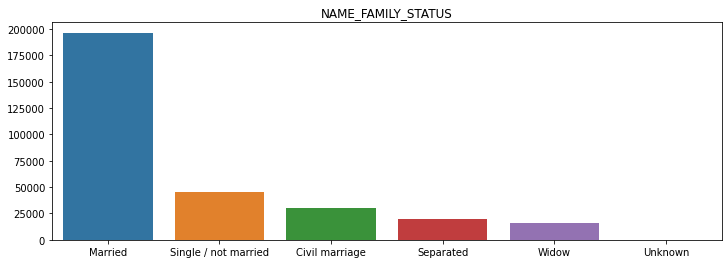

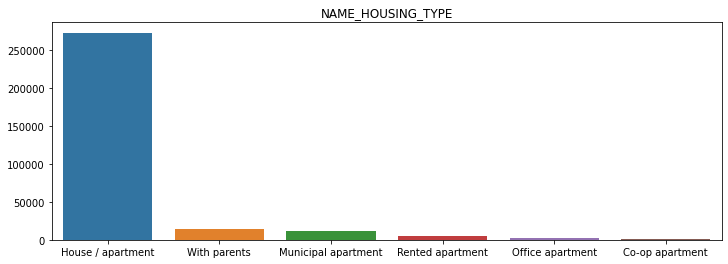

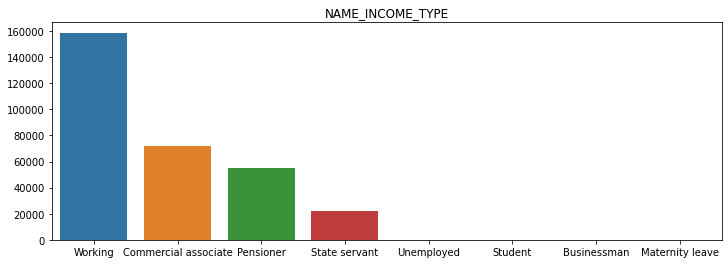

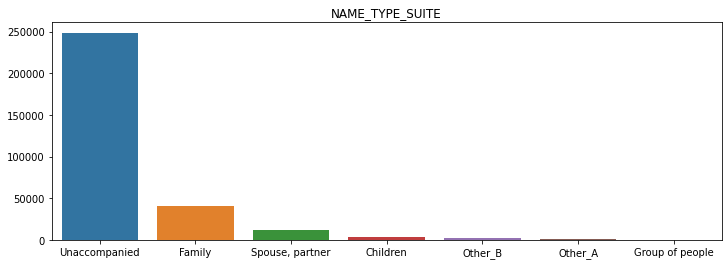

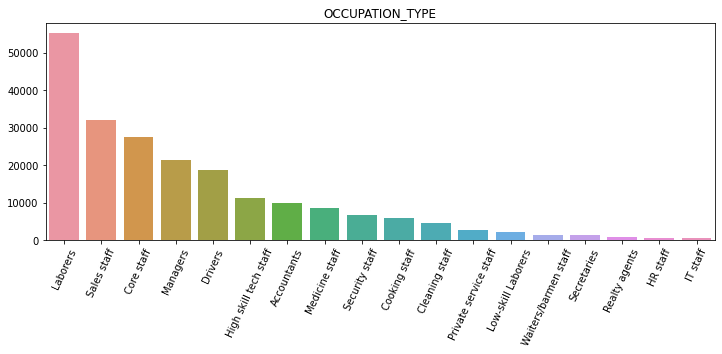

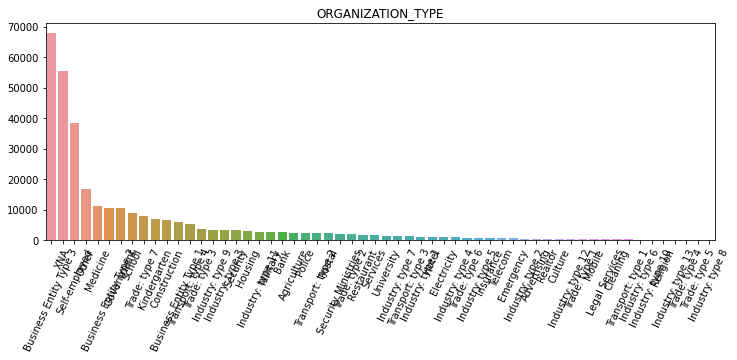

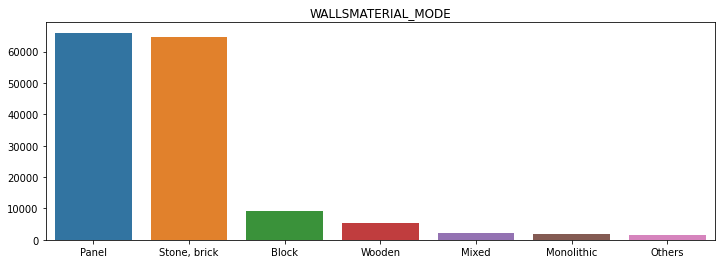

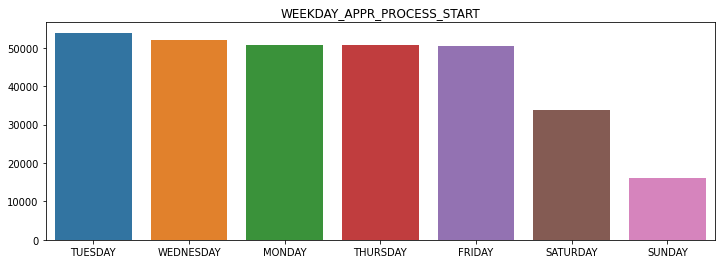

In [10]:
for col in sorted(list(categorical_features)):
    x_angle = 0
    if data[col].nunique() > 10:
        x_angle = 65
    plot_categorical_discrete(data, col, title=col, x_angle=x_angle)

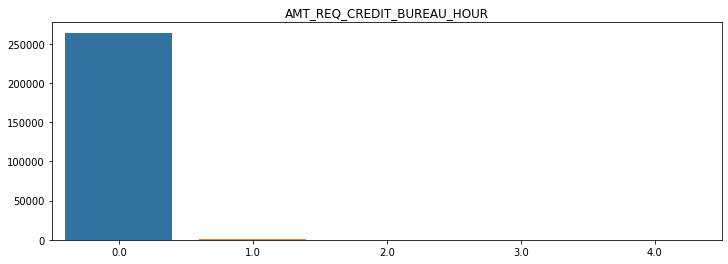

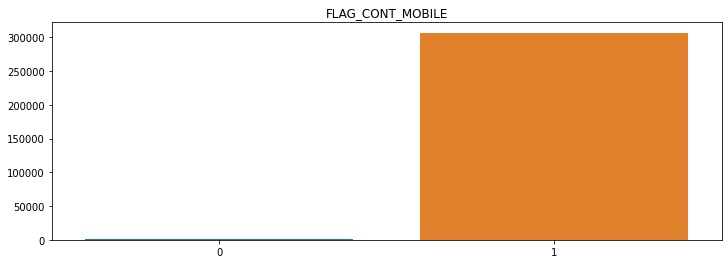

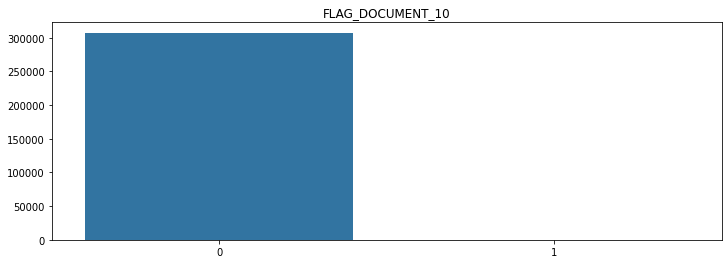

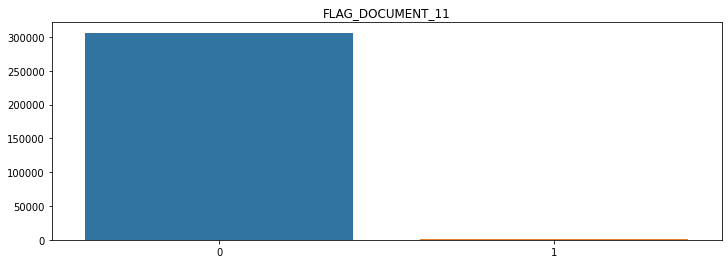

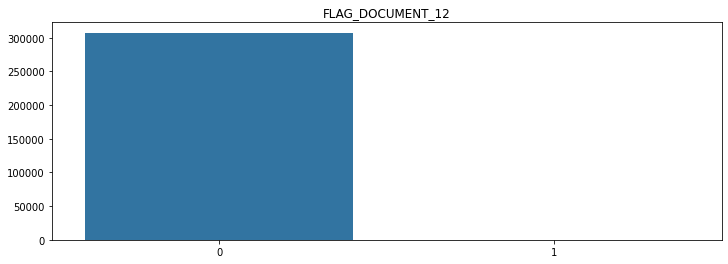

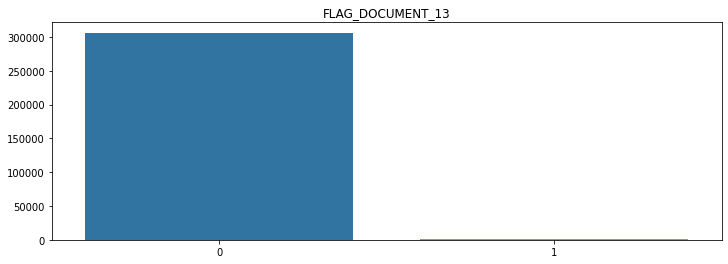

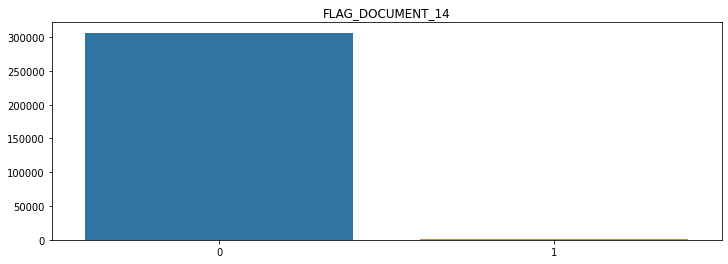

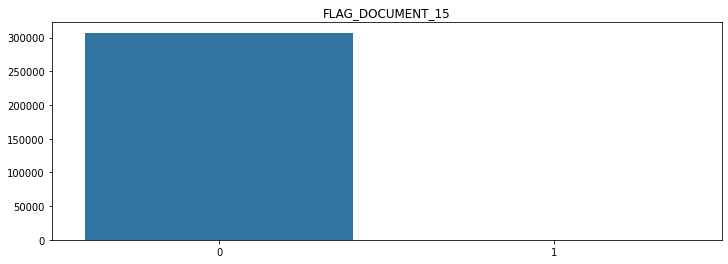

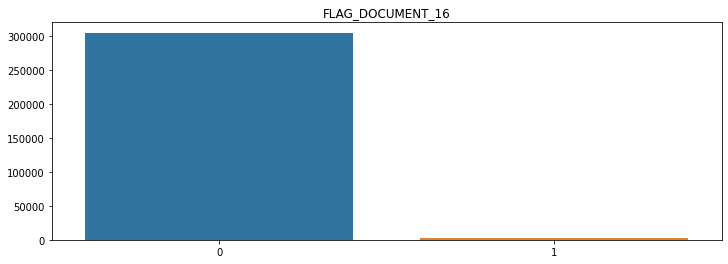

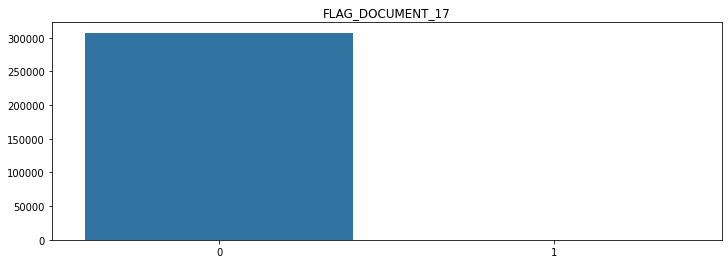

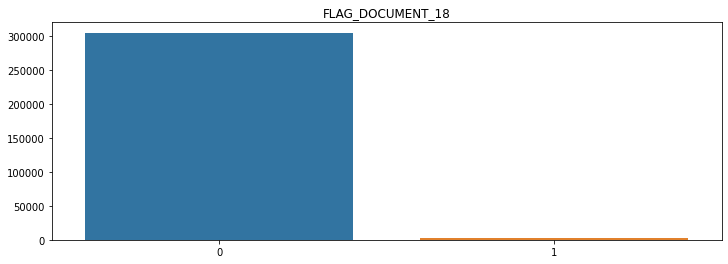

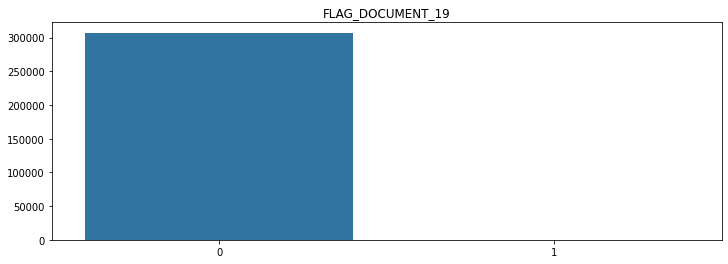

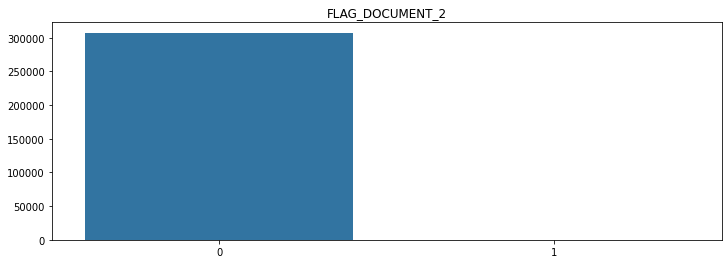

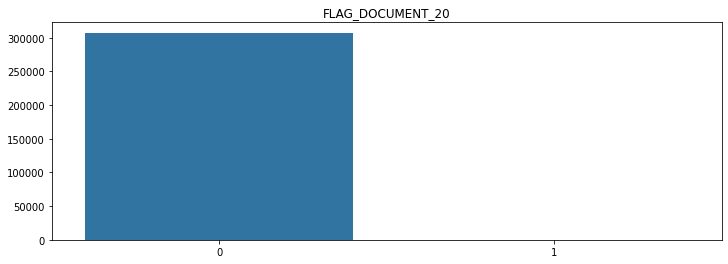

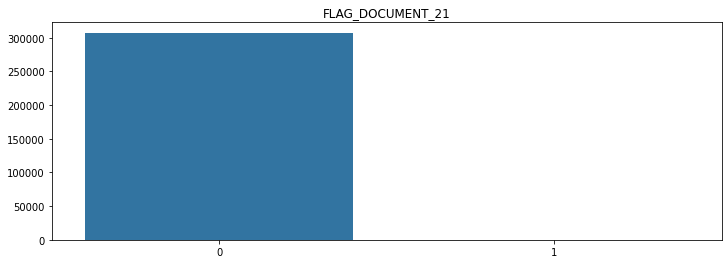

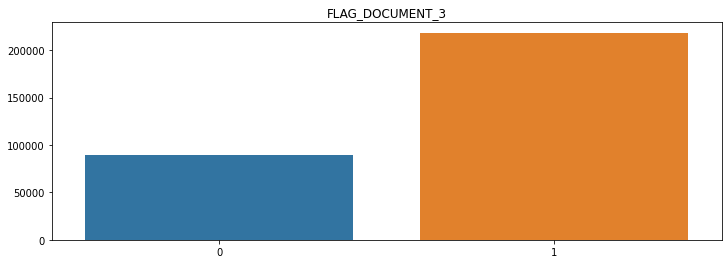

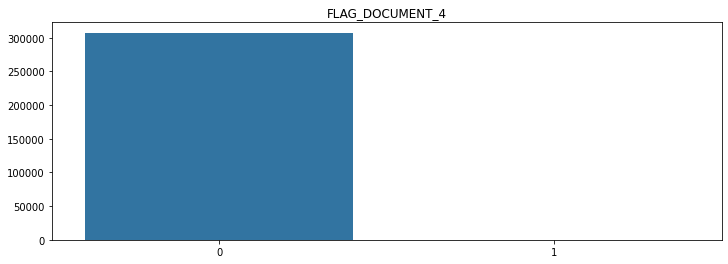

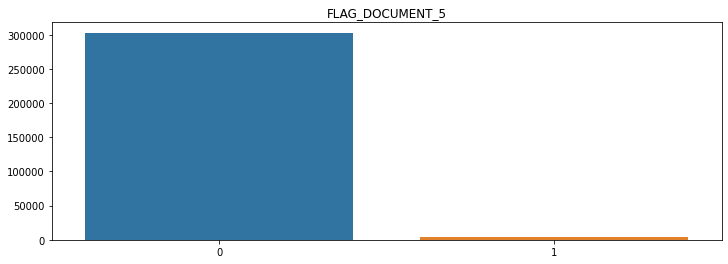

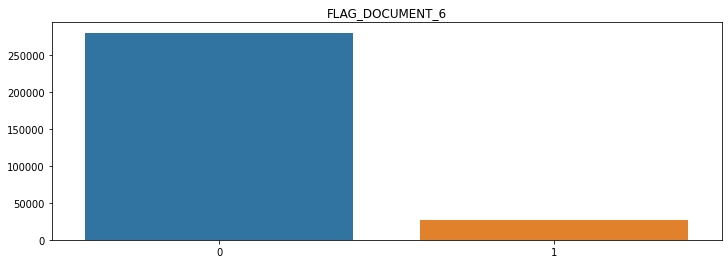

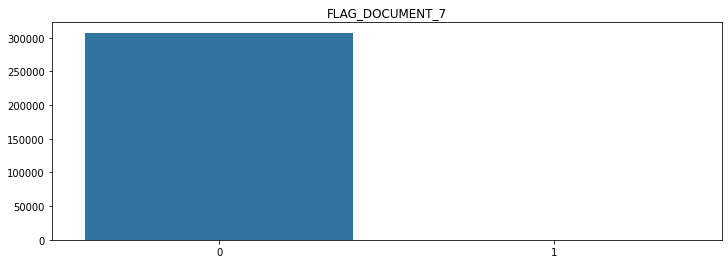

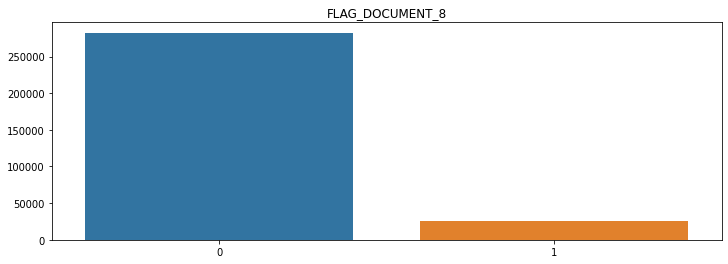

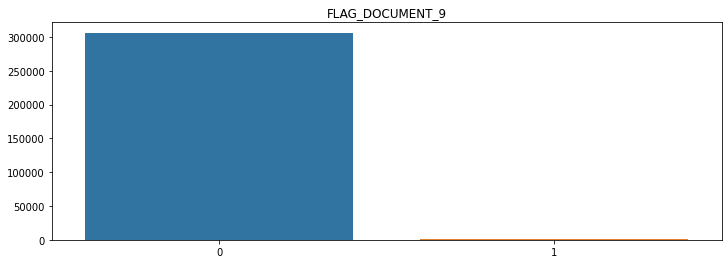

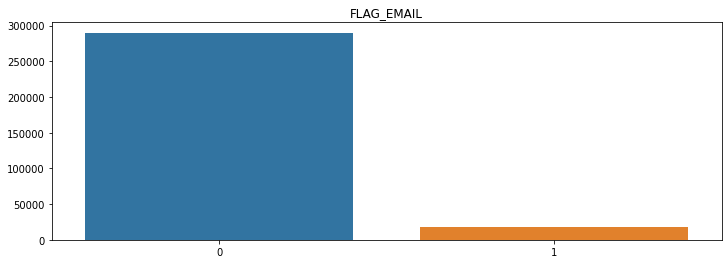

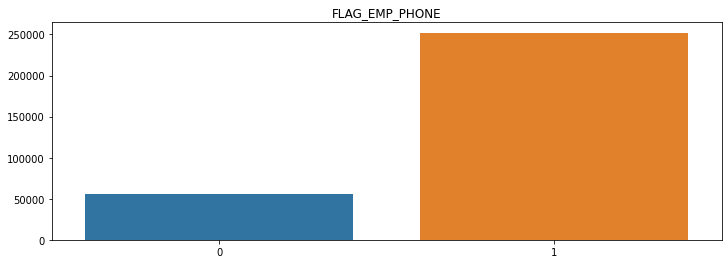

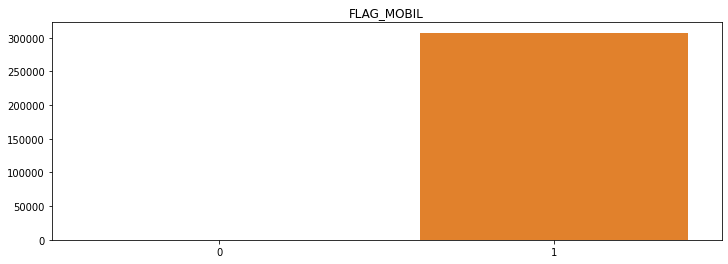

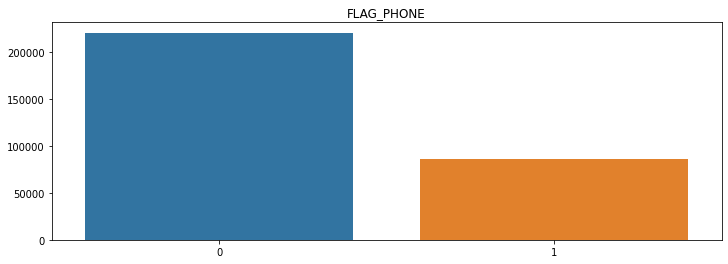

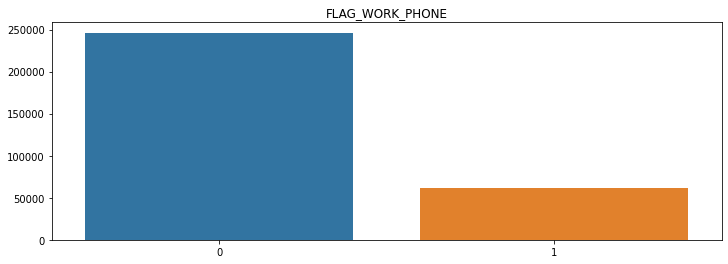

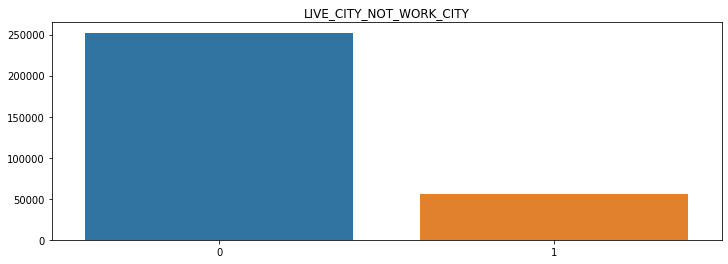

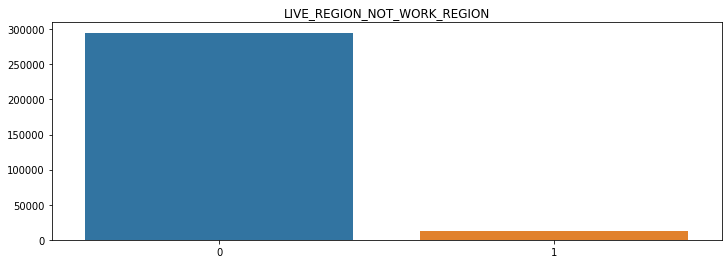

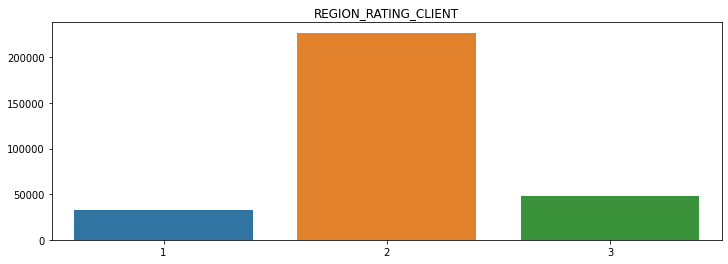

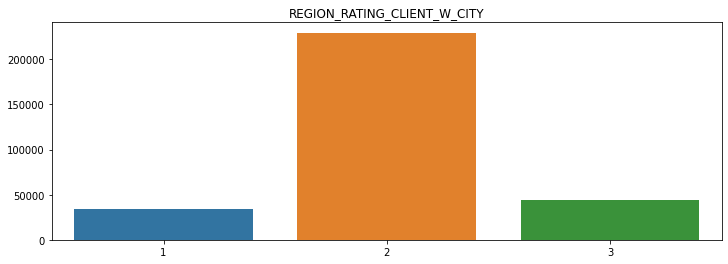

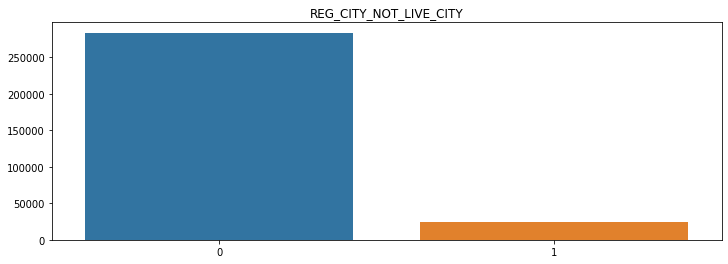

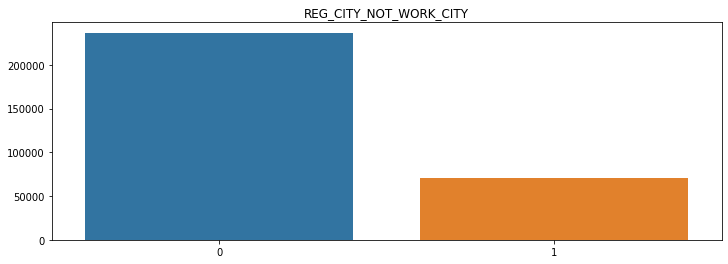

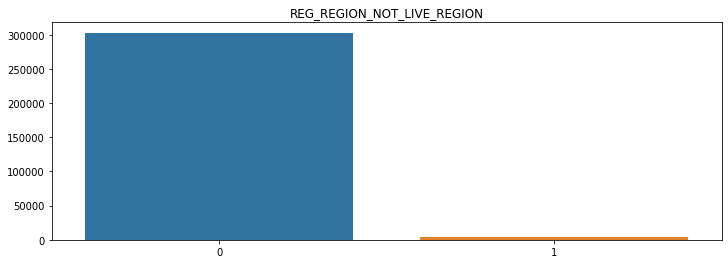

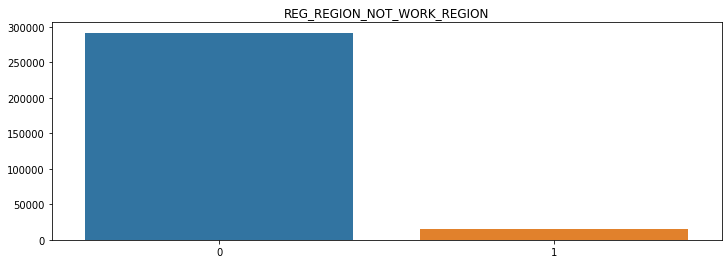

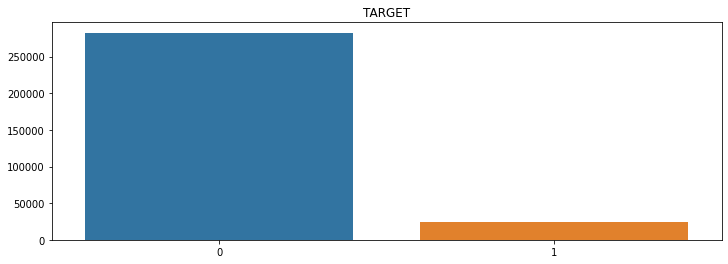

In [11]:
for col in sorted(list(discrete_features)):
    x_angle = 0
    if data[col].nunique() > 10:
        x_angle = 65
    plot_categorical_discrete(data, col, title=col, x_angle=x_angle)

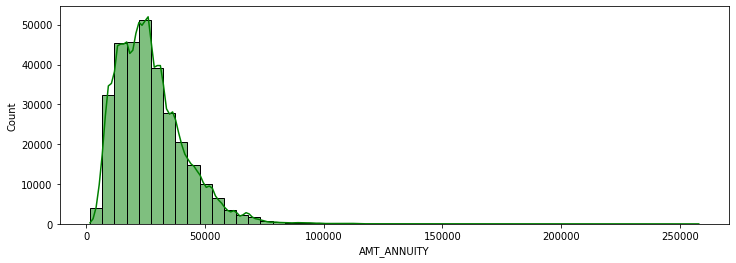

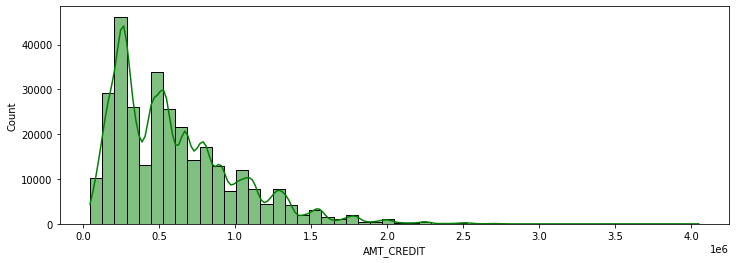

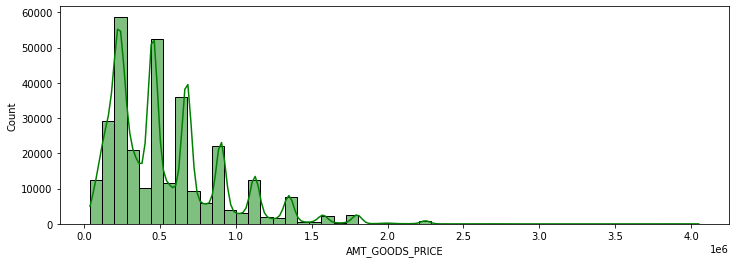

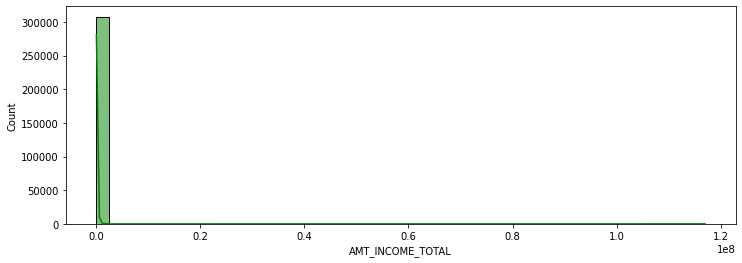

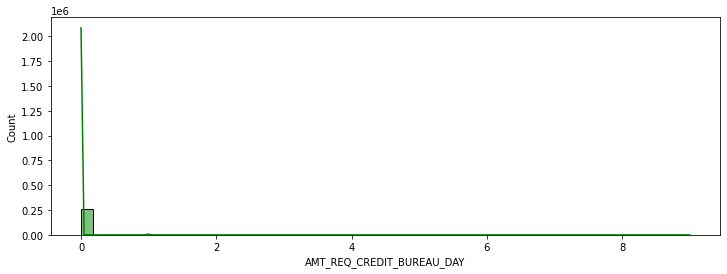

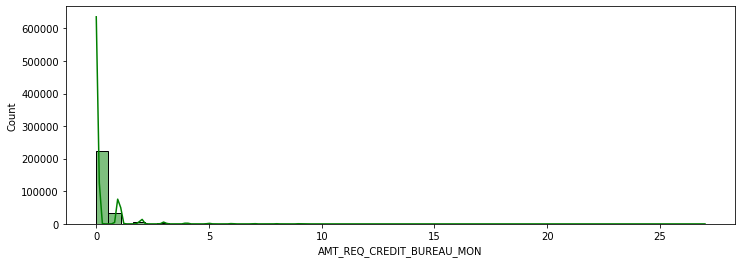

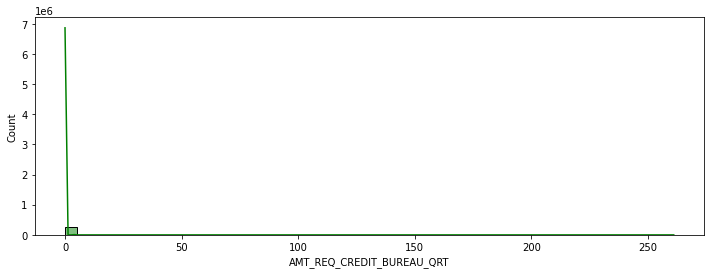

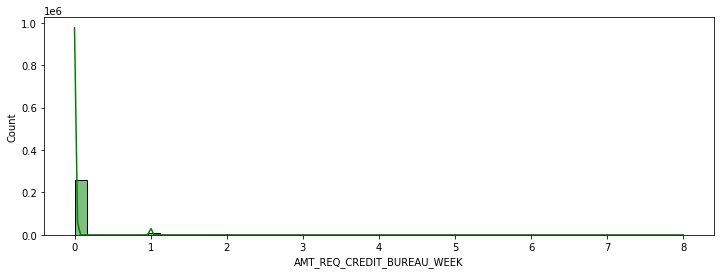

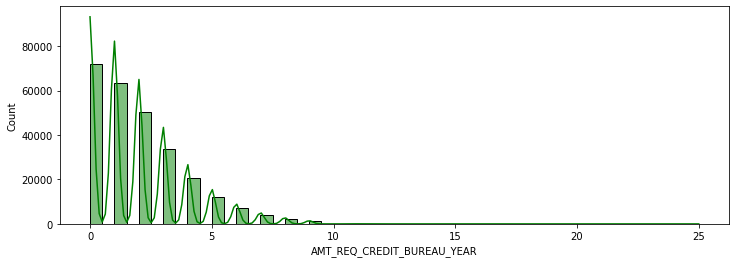

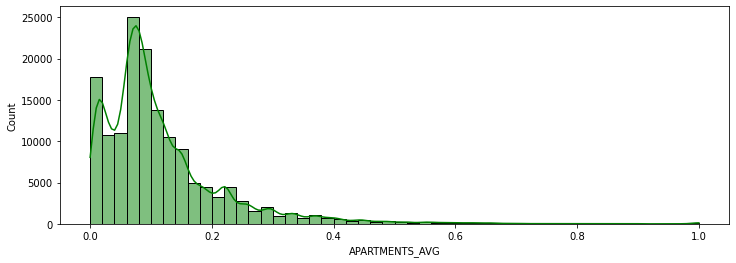

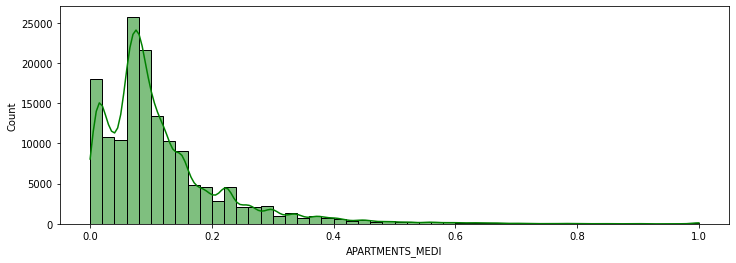

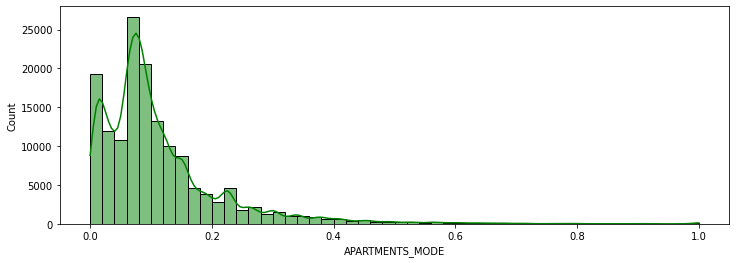

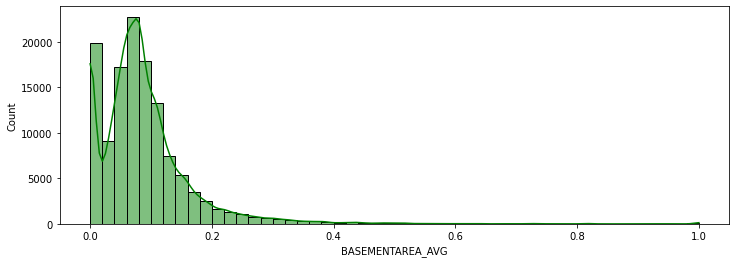

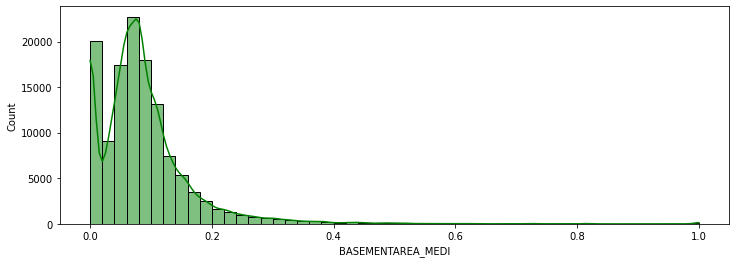

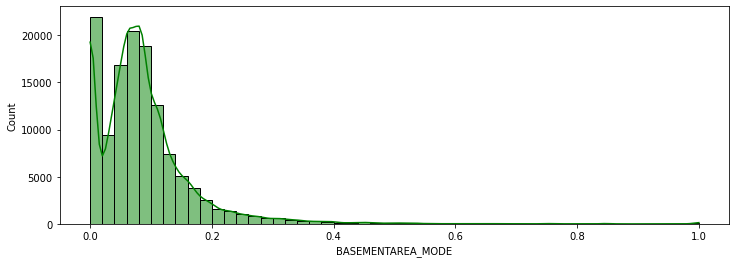

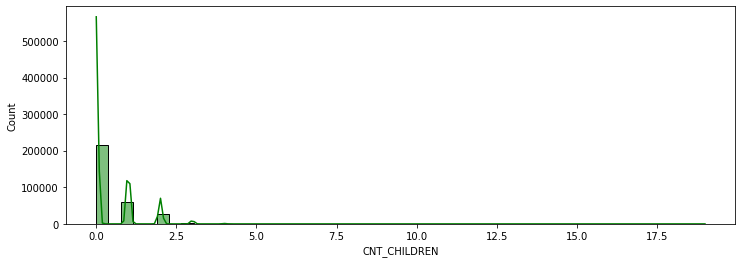

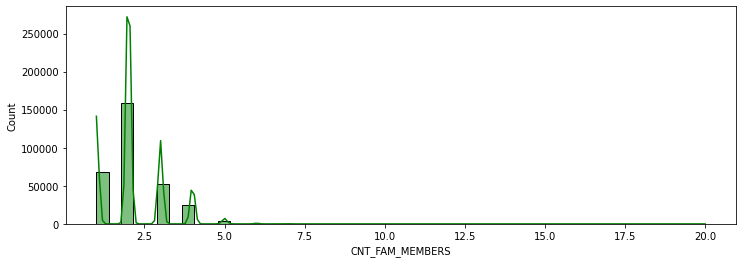

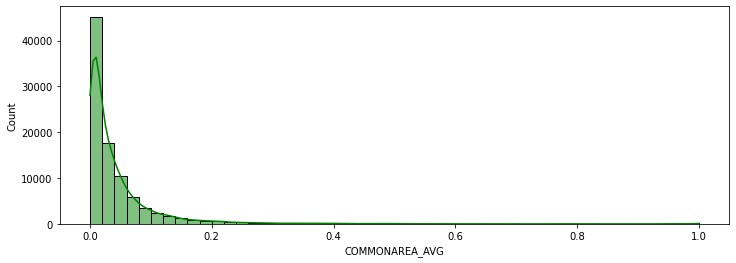

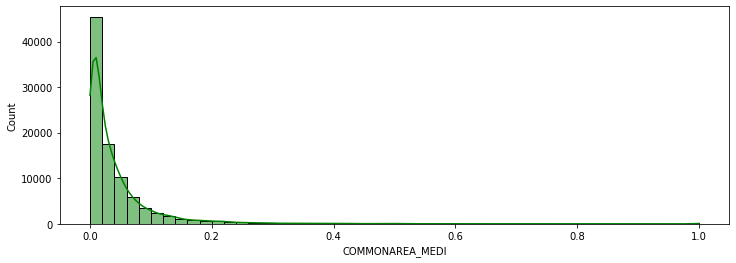

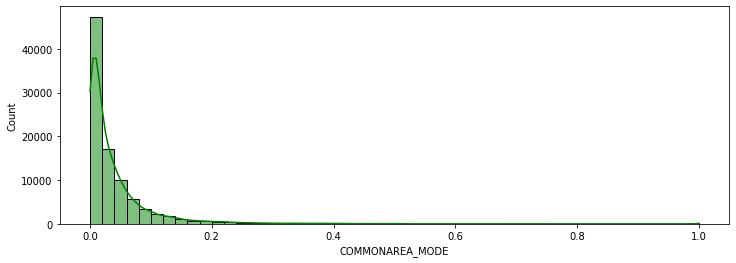

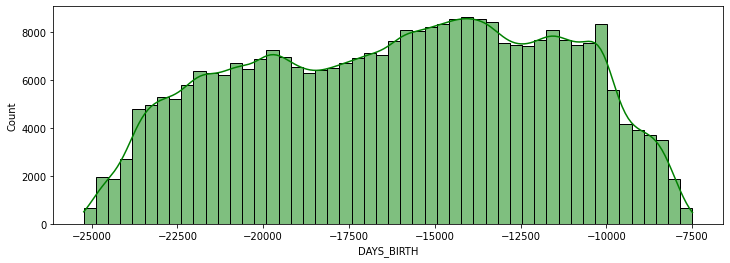

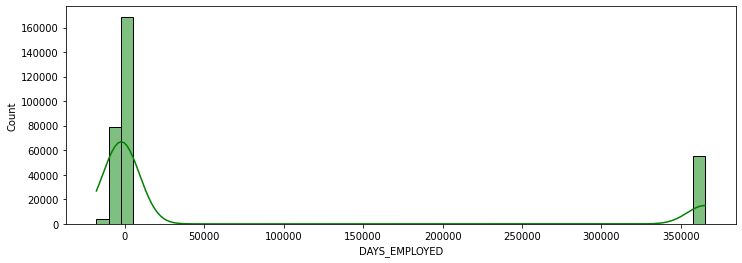

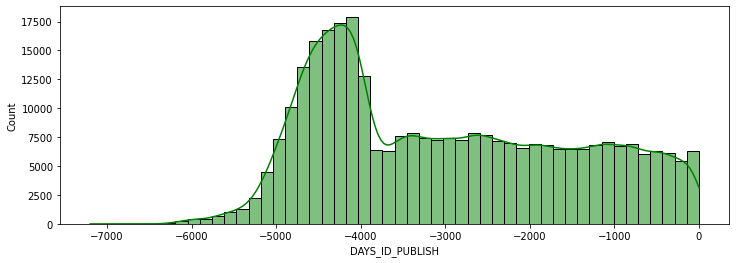

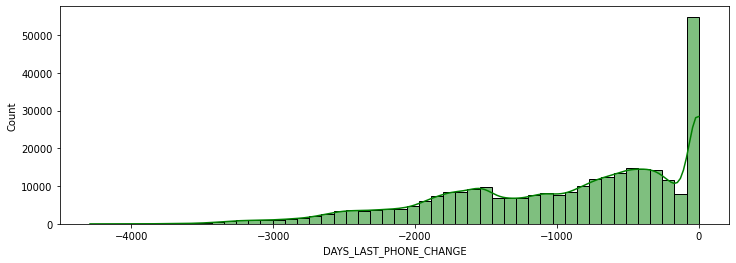

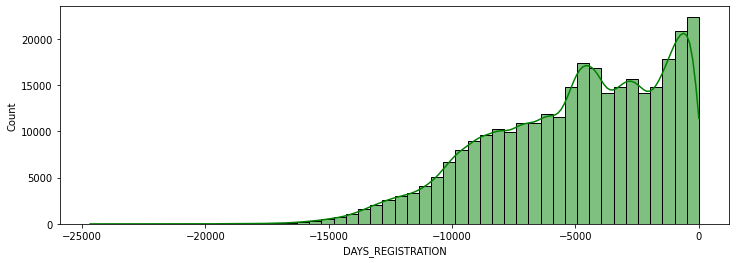

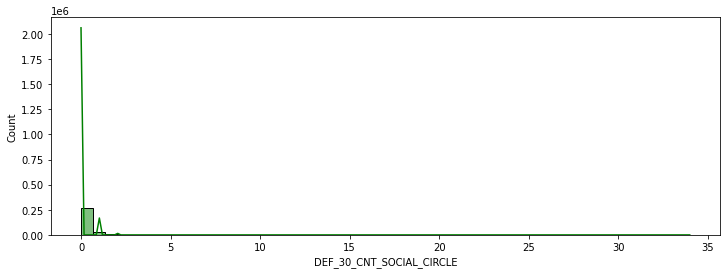

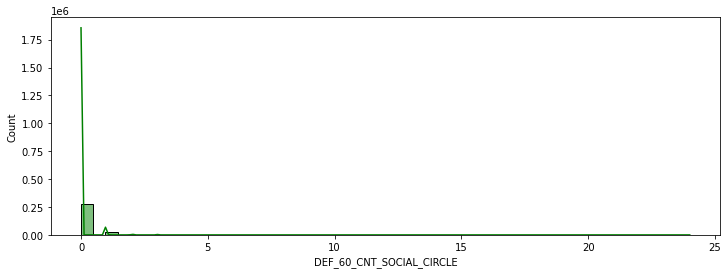

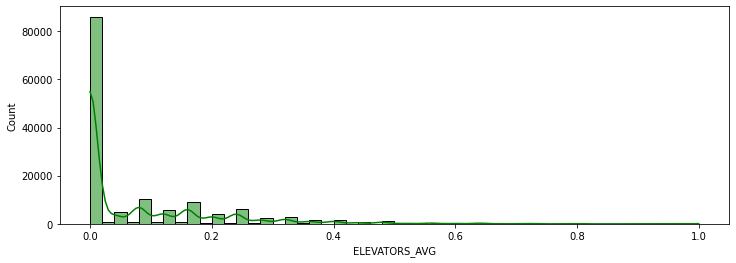

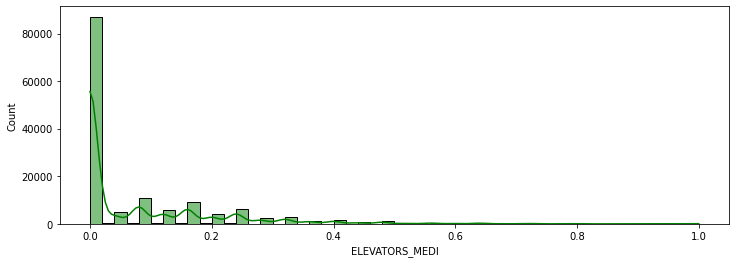

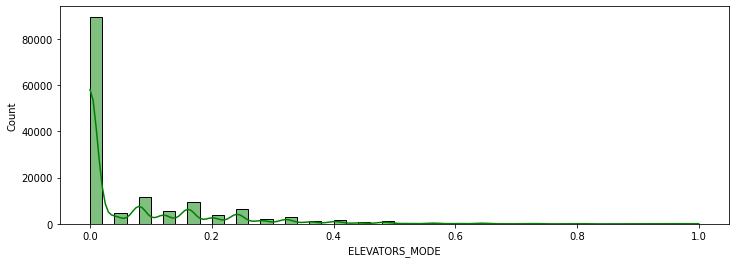

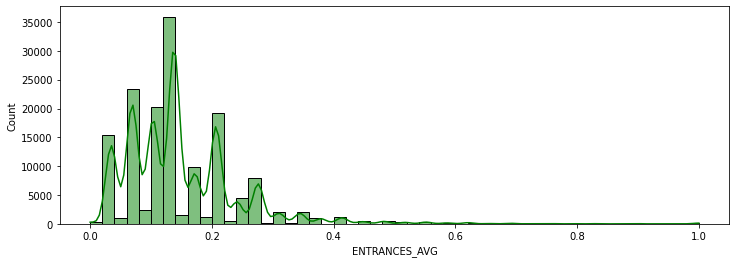

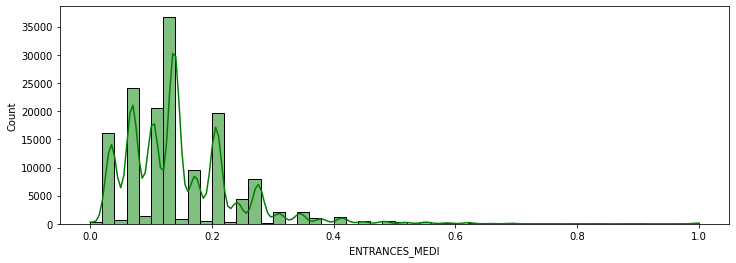

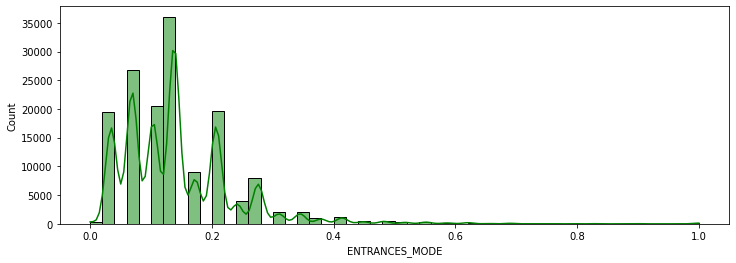

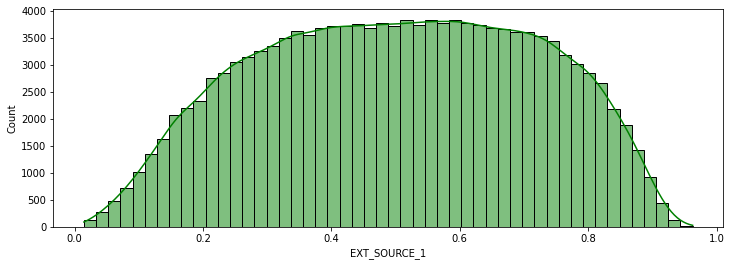

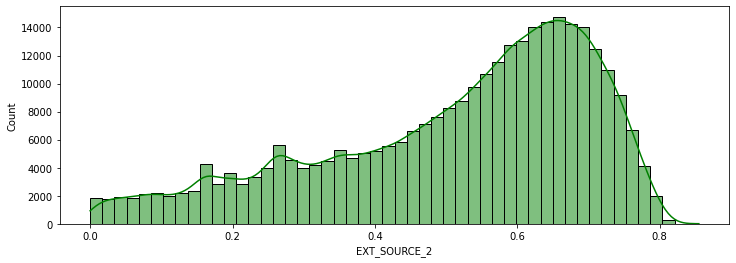

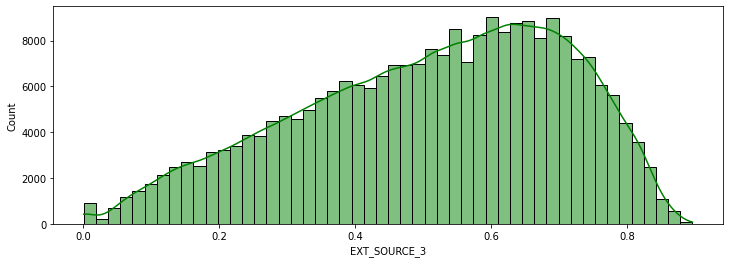

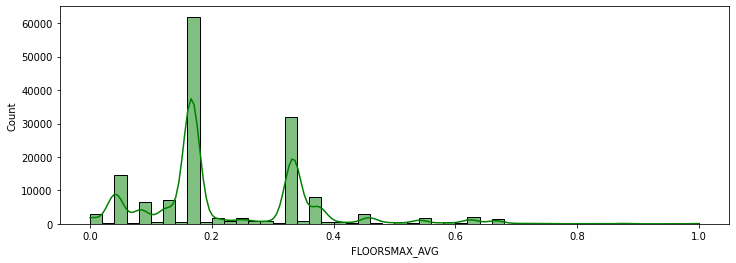

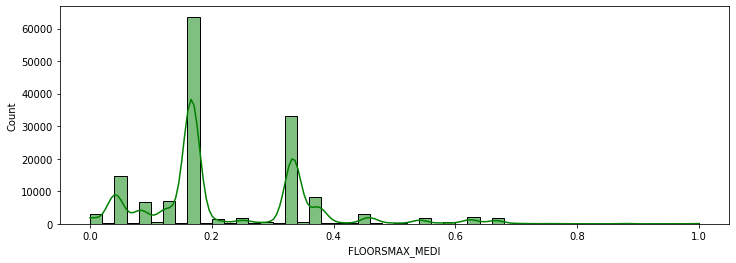

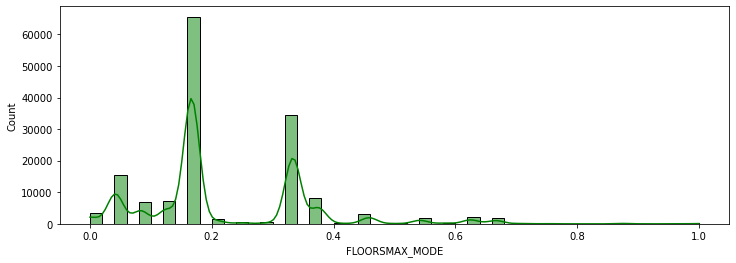

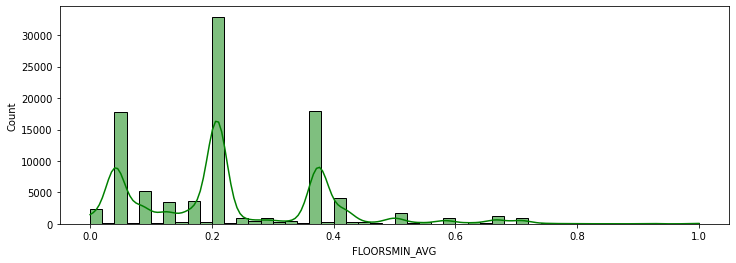

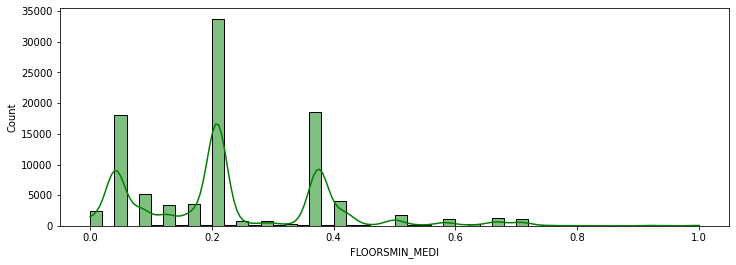

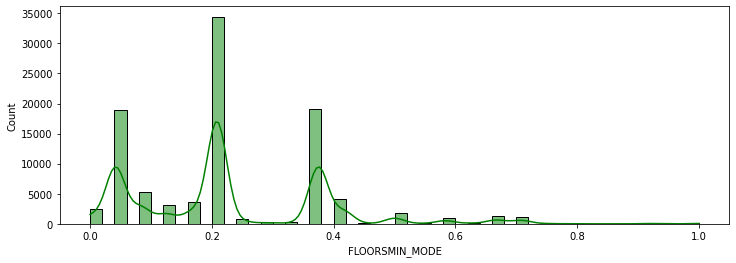

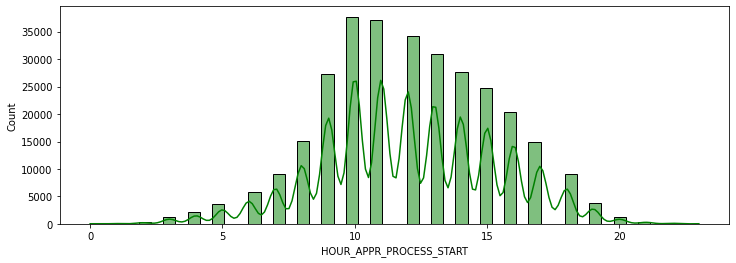

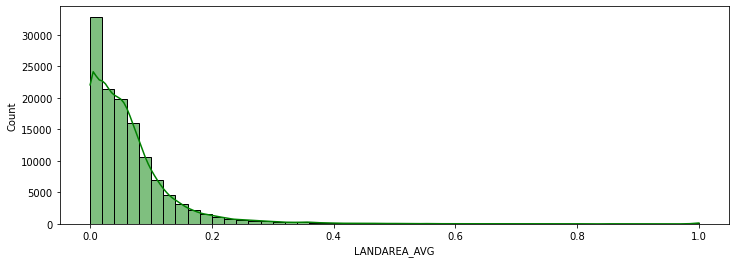

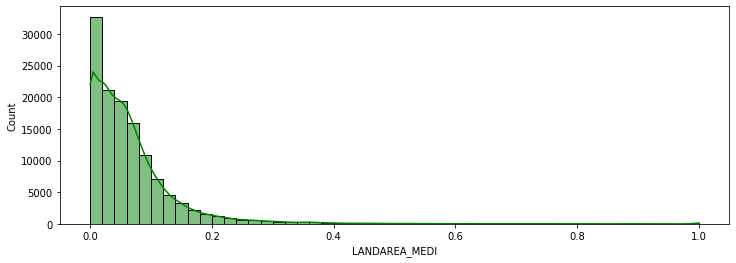

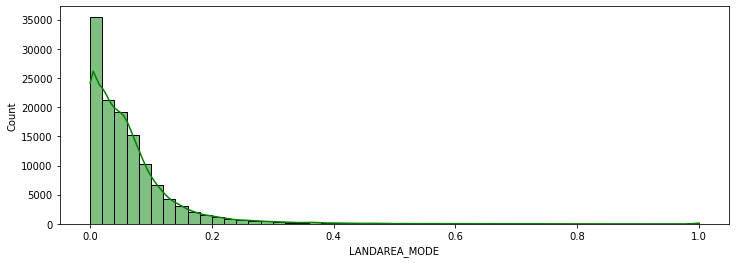

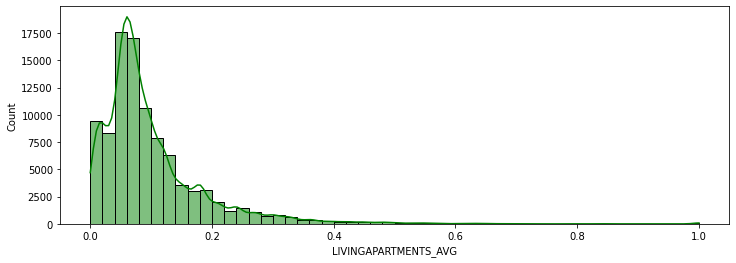

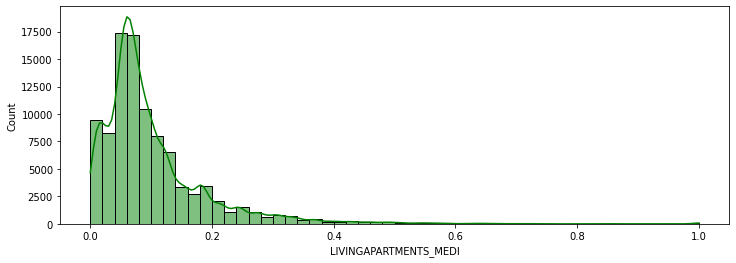

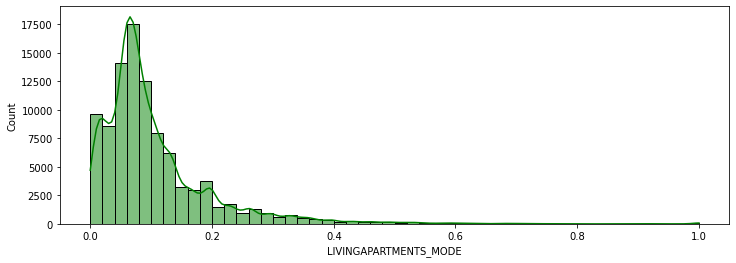

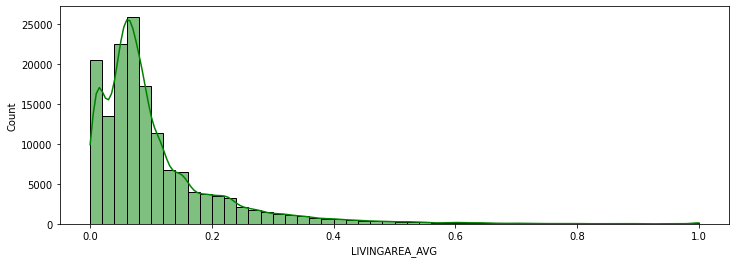

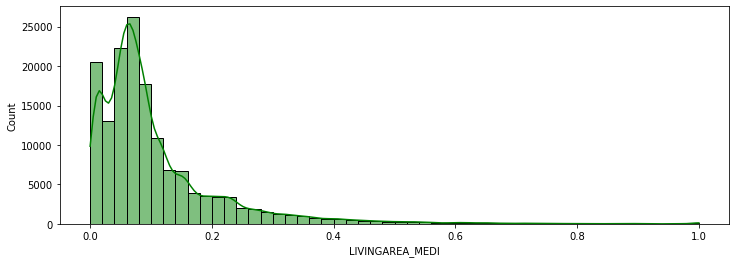

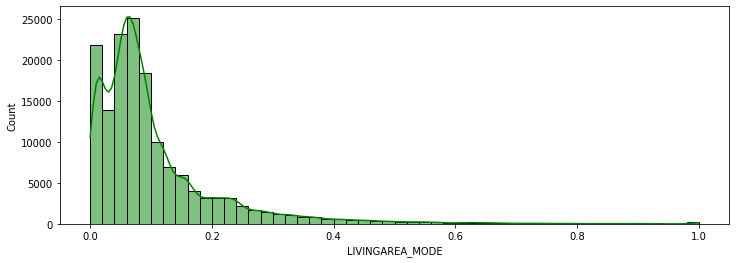

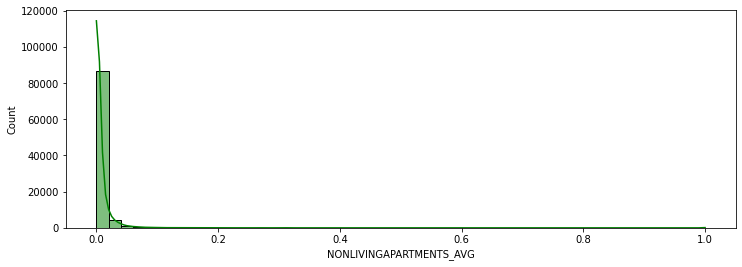

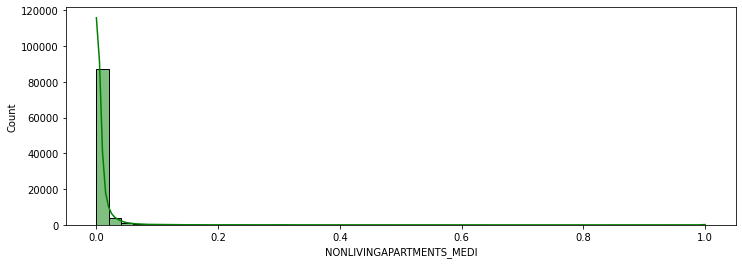

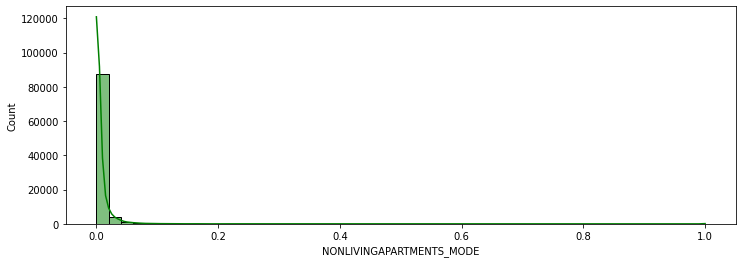

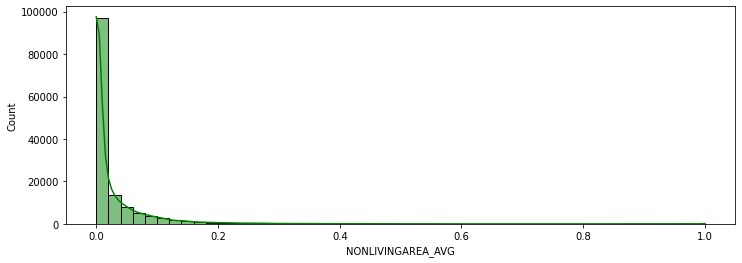

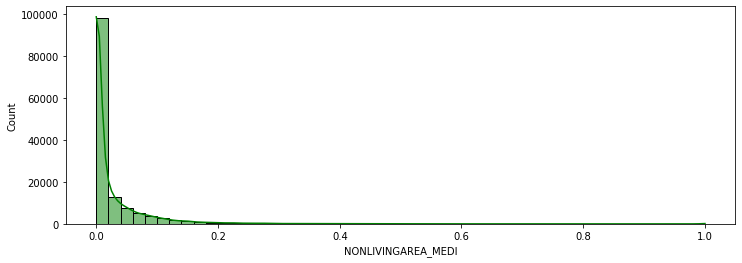

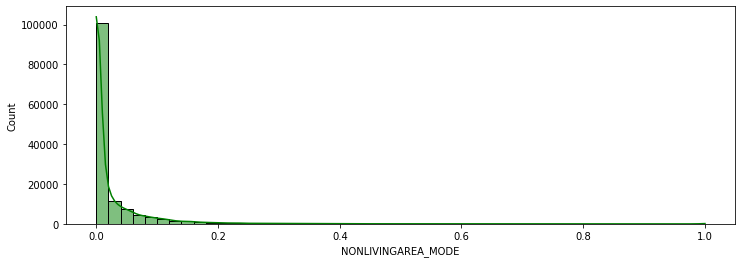

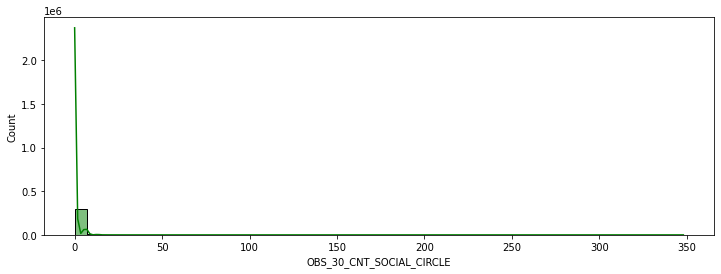

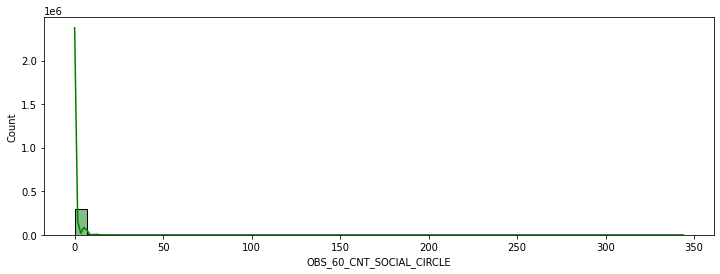

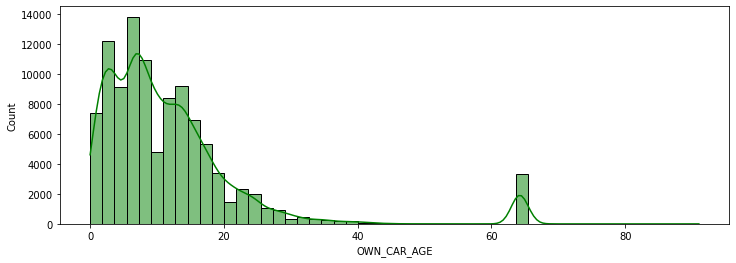

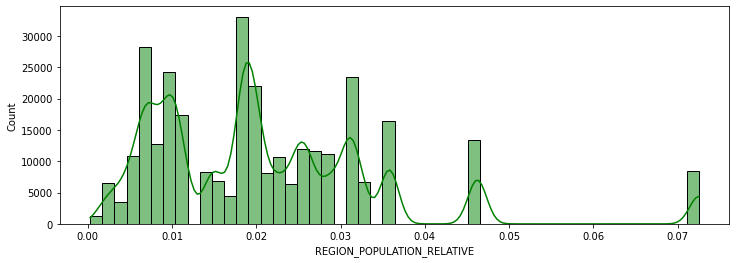

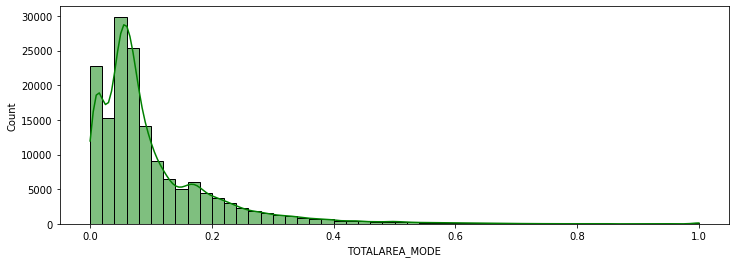

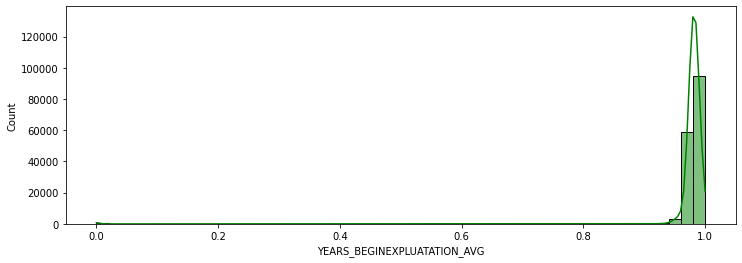

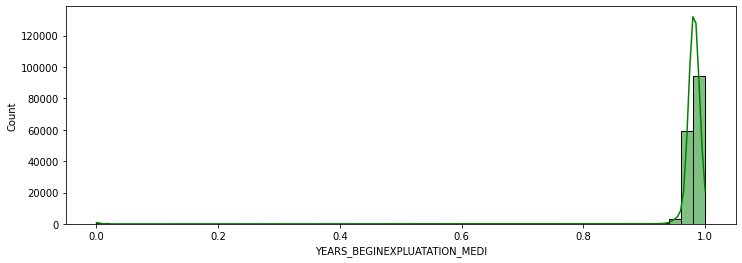

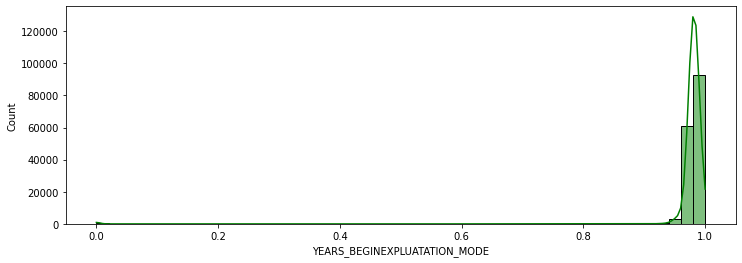

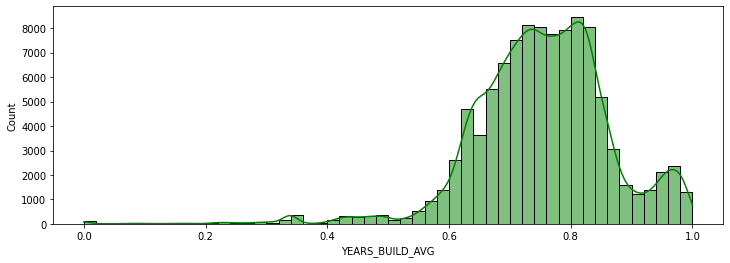

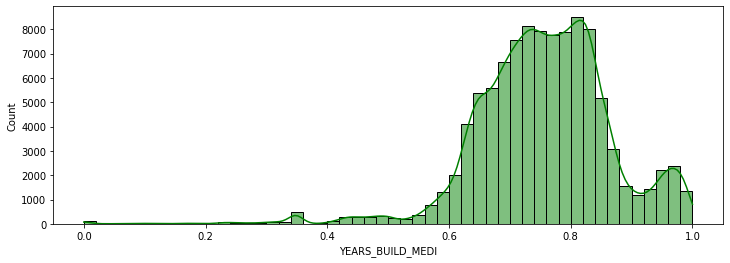

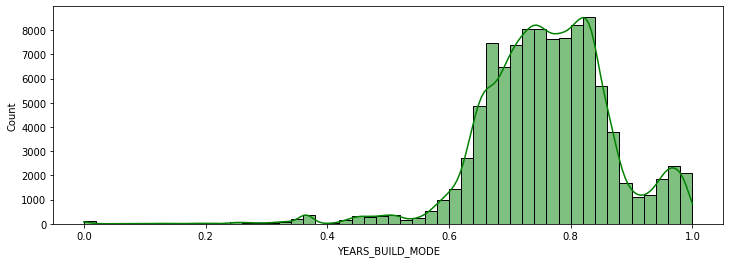

In [12]:
for feature in sorted(list(continuous_features)):
    plot_continuous(data, feature)

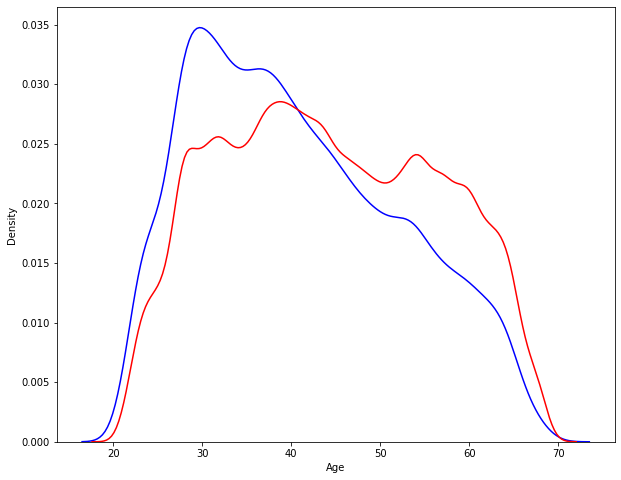

In [13]:
plt.figure(figsize = (10, 8))

sns.kdeplot(data.loc[data['TARGET'] == 1, 'DAYS_BIRTH'] / -365, color='b', label = '123')
sns.kdeplot(data.loc[data['TARGET'] == 0, 'DAYS_BIRTH'] / -365, color='r', label = '234')

plt.xlabel('Age')
plt.show()

From the above plot we can say that people in the age group 25- 35 are less likely to pay back the loan and people in the age group 35-50 number of people who failed to repay the loan is higher in the age group 35-50 are more likely to pay back

### EDA conclusions
- Target class is imbalanced
- There is a trend where the client's age increasing, the probability of client defaulted decreasing
- Most of the loans are cash loans
- Almost all clients provide mobile phone and the phone numbers are reachable, instead of emails.
- Clients registered address are mostly in the same city where they live, but not where their work
- Two-third of clients don't have their own car, but two-third of them have their own home
- Some annomalities in AMT_INCOME_TOTAL and DAYS_EMPLOYED

# Data preparations

In [14]:
# handling annomal values

data['AMT_INCOME_TOTAL'] = data['AMT_INCOME_TOTAL'].apply(lambda x: np.nan if x > 100000000 else x)
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(lambda x: np.nan if x > 0 else x)

In [15]:
# encoding categorical features

for name in categorical_features:
    encoder = LabelEncoder()
    encoder.fit(list(data[name].values.astype('str')) + list(data_test[name].values.astype('str')))
    data_test[name] = encoder.transform(data_test[name].values.astype('str'))
    data[name] = encoder.transform(data[name].values.astype('str'))

In [16]:
# Replacing nan with mean values

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

cols = data.columns
test_cols = data_test.columns
data[cols] = imputer.fit_transform(data)
data_test[test_cols] = imputer.fit_transform(data_test)

# num_rows = data.shape[0]
# for column in data.columns:
#     if (data[column].isnull().sum() / num_rows) > 0.4: # 123,000 NaN, if more than 40% is NaN TODO remove
        
#         print(column, data[column].isnull().sum())
#         try:
#             categorical_features.remove(column)
#         except KeyError:
#             pass
        
#         try:
#             numerical_features.remove(column)
#         except KeyError:
#             pass
#         data = data.drop(columns=[column])

In [17]:
# Regularization

X = data.drop('TARGET', axis=1)
y = data['TARGET']
clf = Lasso(alpha=0.005, max_iter=10000)
scaler = StandardScaler()
clf.fit(scaler.fit_transform(X), y)

final_features = []
for i in range(len(list(X))):
    if clf.coef_[i]:
        final_features.append(list(X)[i])

print('There are ', len(final_features), ' features that will be used, they are: ', final_features)

There are  16  features that will be used, they are:  ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3']


In [18]:
feature_importance = pd.DataFrame(data=np.abs(clf.coef_), index=list(X), columns=['Importance'])
feature_importance = feature_importance[feature_importance['Importance'] != 0].sort_values(by='Importance', ascending=False)
feature_importance

,Importance
EXT_SOURCE_3,0.032396
EXT_SOURCE_2,0.032167
EXT_SOURCE_1,0.010607
CODE_GENDER,0.006814
NAME_EDUCATION_TYPE,0.005874
DAYS_EMPLOYED,0.005743
FLAG_DOCUMENT_3,0.004095
FLAG_OWN_CAR,0.001973
DAYS_ID_PUBLISH,0.001765
DEF_30_CNT_SOCIAL_CIRCLE,0.001328


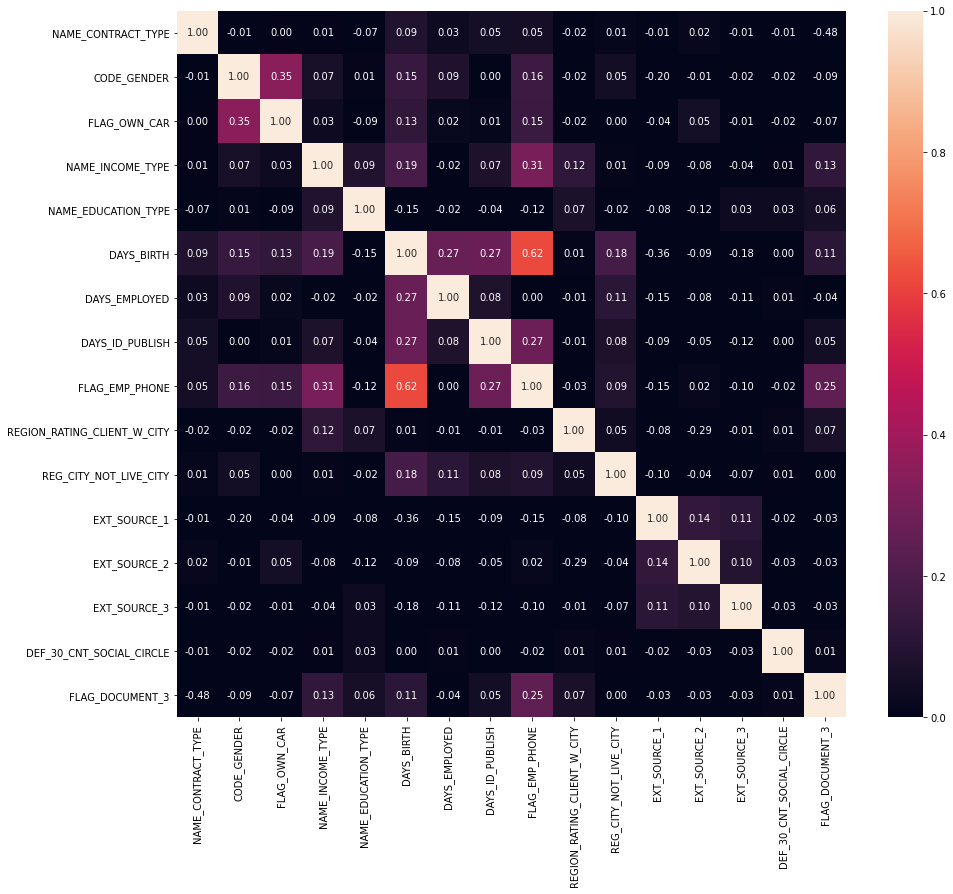

In [19]:
plt.figure(figsize=(15,13))
_ = sns.heatmap(X[final_features].corr(), annot=True, fmt='.2f', vmin=0, vmax=1)

In [20]:
final_train = pd.concat([X[final_features],y],axis=1)
final_test = data_test[final_features]
final_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_3,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,
100002,0.0,1.0,0.0,7.0,4.0,-9461.0,-637.0,-2120.0,1.0,2.0,0.0,0.083037,0.262949,0.139376,2.0,1.0,1.0
100003,0.0,0.0,0.0,4.0,1.0,-16765.0,-1188.0,-291.0,1.0,1.0,0.0,0.311267,0.622246,0.510853,0.0,1.0,0.0
100004,1.0,1.0,1.0,7.0,4.0,-19046.0,-225.0,-2531.0,1.0,2.0,0.0,0.502130,0.555912,0.729567,0.0,0.0,0.0
100006,0.0,0.0,0.0,7.0,4.0,-19005.0,-3039.0,-2437.0,1.0,2.0,0.0,0.502130,0.650442,0.510853,0.0,1.0,0.0
100007,0.0,1.0,0.0,7.0,4.0,-19932.0,-3038.0,-3458.0,1.0,2.0,0.0,0.502130,0.322738,0.510853,0.0,0.0,0.0


# Getting predictions

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    final_train.drop('TARGET', axis=1), final_train['TARGET'], test_size=0.2, random_state=42
)

In [22]:
scaler = StandardScaler()
model = LogisticRegression(max_iter=1000, class_weight='balanced')
fitted_X_train = scaler.fit_transform(X_train)

_ = model.fit(fitted_X_train, y_train)

In [23]:
print('train AUC =', roc_auc_score(y_train, model.predict_proba(fitted_X_train)[:,1]))
print('test AUC =', roc_auc_score(y_test, model.predict_proba(scaler.fit_transform(X_test))[:,1]))

train AUC = 0.7388999890791608
test AUC = 0.7401353836718788


In [24]:
prediction = model.predict_proba(scaler.fit_transform(final_test))
prediction_df = pd.DataFrame(prediction[:,1], index=final_test.index, columns=['TARGET'])
prediction_df.to_csv('submission.csv')

![](home_credit_result.png)